In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [2]:
data = loadmat('data/compEx1data.mat')
x = data['x']
x1s = x[0][0]
x2s = x[1][0]

In [3]:
def normalize_points(x,norm=True):
    mean_x = np.mean(x[0])
    mean_y = np.mean(x[1])
    std_x = np.std(x[0])
    std_y = np.std(x[1])
    if norm == False:
         N = np.array([[1, 0, 0],
                       [0, 1, 0],
                       [0, 0, 1]])
    
    else:
        N = np.array([[1/std_x, 0, -mean_x/std_x],
                      [0, 1/std_y, -mean_y/std_y],
                      [0, 0, 1]])
    x_normalized = N @ x
    return N,x_normalized

def estimate_F_DLT(x1s, x2s, path, tolerance=1e-2, norm=True):
    N1, x1n = normalize_points(x1s, norm)
    N2, x2n = normalize_points(x2s, norm)
    M = []
    for i in range(x1n.shape[1]):
        x1, y1, _ = x1n[:, i]
        x2, y2, _ = x2n[:, i]
        M.append([x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1])
    M = np.array(M)

    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1]
    F_tilde = v.reshape(3, 3)

    min_singular_value = S[-1]
    residual = np.linalg.norm(M @ v)
    print(f"Minimum singular value: {min_singular_value}")
    print(f"Residual ||M v||: {residual}")
    
    F = enforce_fundamental(F_tilde)

    epipolar_constraints = np.einsum('ij,ji->i', x2n.T, F_tilde @ x1n)
    
    
    F = N2.T @ F @ N1
    F = F / F[-1][-1]
    print("Fundamental Matrix:")
    print(F)

    plot_epipolar_constraints(epipolar_constraints,path)
    
    return F

def enforce_fundamental(F):
    U, S, Vt = np.linalg.svd(F)
    S[2] = 0
    F_enforced = U @ np.diag(S) @ Vt
    return F_enforced

def compute_epipolar_errors(F, x1s, x2s):
    l2 = F @ x1s
    l2 /= np.sqrt(l2[0, :]**2 + l2[1, :]**2)

    distances = np.abs(np.sum(l2 * x2s, axis=0))
    return distances

def plot_epipolar_lines(image, points, epipolar_lines, path):
    plt.imshow(image, cmap='gray')
    plt.scatter(points[0, :], points[1, :], c='red', marker='o', s=15)

    for i in range(epipolar_lines.shape[1]):
        a, b, c = epipolar_lines[:, i]
        x = np.linspace(0, image.shape[1], 100)
        y = -(a * x + c) / b
        plt.plot(x, y)

    plt.xlim(0,1936)
    plt.ylim(1296,0)
    plt.savefig(path)
    plt.show()

def plot_epipolar_constraints(epipolar_constraints,path):
    plt.figure(figsize=(8, 6))
    plt.hist(epipolar_constraints, bins=50, edgecolor='black')
    plt.title("Distribution of Epipolar Constraint Violations")
    plt.xlabel("Constraint Value (x2'.T @ F' @ x1')")
    plt.ylabel("Frequency")
    plt.savefig(path)
    plt.show()



############## NORMALISED CASE ##############
Minimum singular value: 0.04965450019510648
Residual ||M v||: 0.04965450019510676
Fundamental Matrix:
[[-3.39010693e-08 -3.72005338e-06  5.77231283e-03]
 [ 4.66736903e-06  2.89360833e-07 -2.66821034e-02]
 [-7.19360374e-03  2.62957109e-02  1.00000000e+00]]


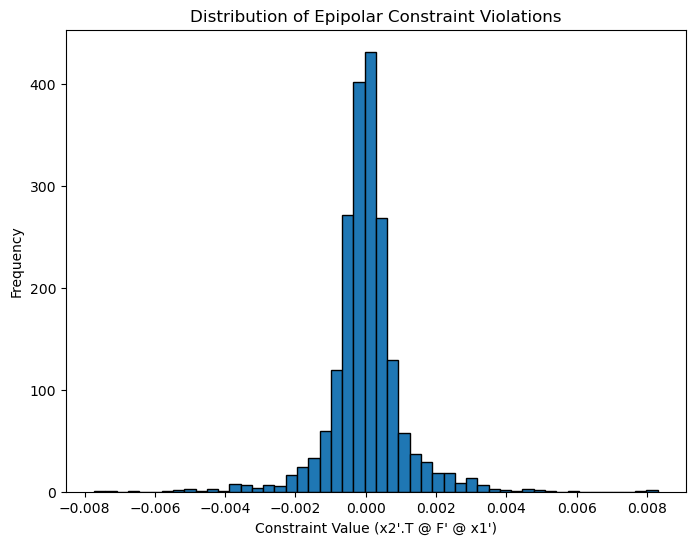

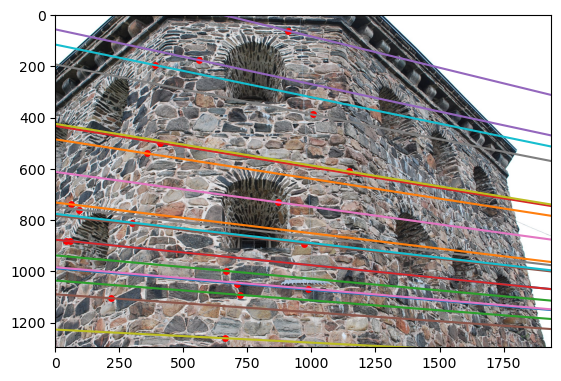

Mean distance from points to epipolar lines: 0.36123310274807563


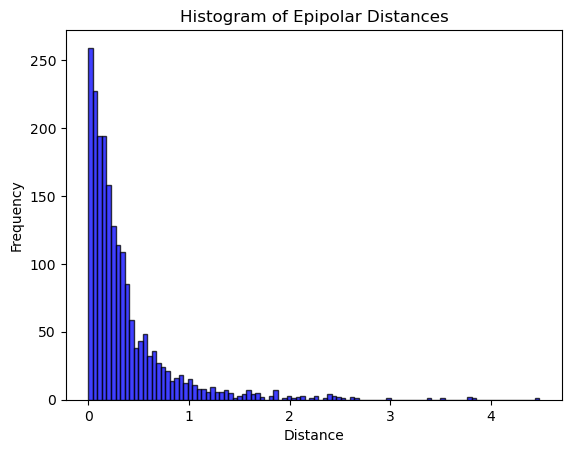

In [4]:
img1 = imread('data/kronan1.jpg')
img2 = imread('data/kronan2.jpg')

print("############## NORMALISED CASE ##############")

F = estimate_F_DLT(x1s, x2s,"figs/norm_constraint_ex1.png")

num_points = x1s.shape[1]
random_indices = np.random.choice(num_points, 20, replace=False)
selected_x1s = x1s[:, random_indices]
selected_x2s = x2s[:, random_indices]

epipolar_lines_img2 = F @ selected_x1s
epipolar_lines_img2 /= np.sqrt(epipolar_lines_img2[0, :]**2 + epipolar_lines_img2[1, :]**2)

plot_epipolar_lines(img2, selected_x2s, epipolar_lines_img2, "figs/norm_lines.png")

distances = compute_epipolar_errors(F, x1s, x2s)
mean_error = np.mean(distances)
print(f"Mean distance from points to epipolar lines: {mean_error}")

plt.hist(distances, bins=100, alpha=0.75, color='blue',edgecolor='black')
plt.title('Histogram of Epipolar Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.savefig("figs/norm_hist.png")
plt.show()


############## UN-NORMALISED CASE ##############
Minimum singular value: 0.5629347767538992
Residual ||M v||: 0.5629347767539152
Fundamental Matrix:
[[-3.15707613e-08 -3.84556425e-06  5.83146057e-03]
 [ 4.78969495e-06  2.81735814e-07 -2.65509899e-02]
 [-7.23662551e-03  2.61541325e-02  1.00000000e+00]]


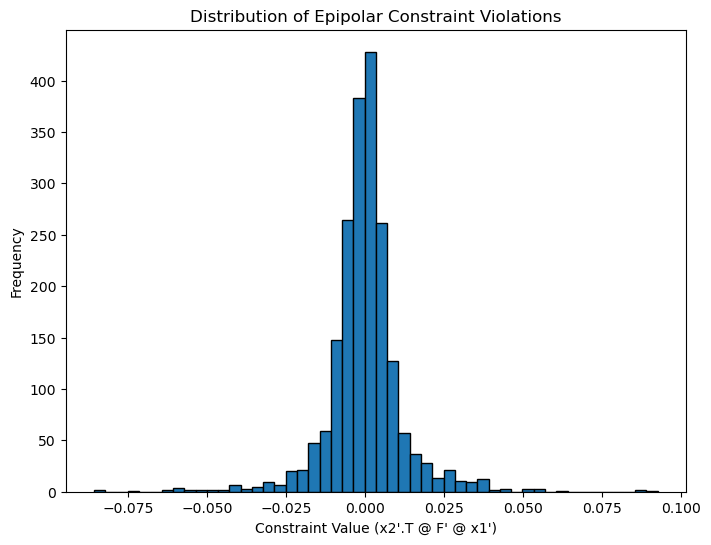

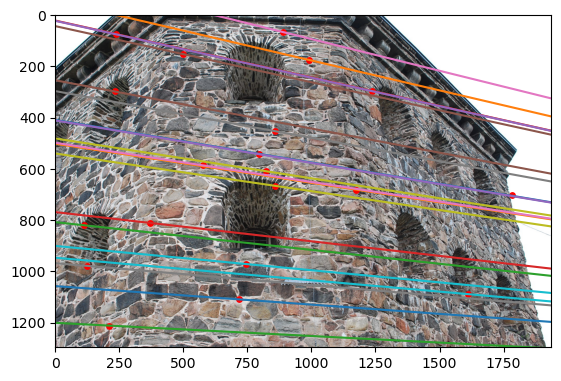

Mean distance from points to epipolar lines: 0.4878403580824664


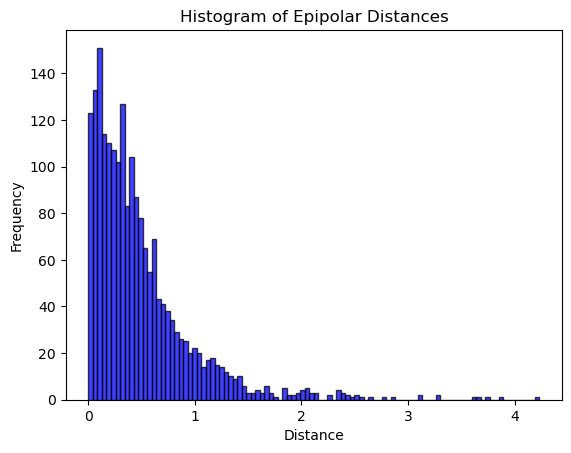

In [5]:
print("############## UN-NORMALISED CASE ##############")
F = estimate_F_DLT(x1s, x2s,"figs/un_norm_constraint_ex1.png",norm=False)

num_points = x1s.shape[1]
random_indices = np.random.choice(num_points, 20, replace=False)
selected_x1s = x1s[:, random_indices]
selected_x2s = x2s[:, random_indices]

epipolar_lines_img2 = F @ selected_x1s
epipolar_lines_img2 /= np.sqrt(epipolar_lines_img2[0, :]**2 + epipolar_lines_img2[1, :]**2)

plot_epipolar_lines(img2, selected_x2s, epipolar_lines_img2,"figs/un_norm_lines.png")

distances = compute_epipolar_errors(F, x1s, x2s)
mean_error = np.mean(distances)
print(f"Mean distance from points to epipolar lines: {mean_error}")

plt.hist(distances, bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Epipolar Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.savefig("figs/un_norm_hist.png")
plt.show()

